<a href="https://colab.research.google.com/github/medha130101/Minor_Project/blob/main/FERResnetFinal(Updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
#from livelossplot import PlotLossesKeras
# from livelossplot import PlotLossesTensorFlowKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.7.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Load the Dataset from the ZIP File

In [3]:
!pip install livelossplot

In [4]:
 print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [5]:
! rm -rf train; mkdir train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/emotion.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/facesdb.zip' -d train
! unzip -q '/content/drive/My Drive/cs230 project/cs230-fer-master/datasets/fer2013/train.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/googlesearch.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/googleset.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/jaffe.zip' -d train
#! unzip -q '/content/drive/My Drive/cs230 project/dataset/umea.zip' -d train

In [6]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/cs230 project/cs230-fer-master/datasets/fer2013/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/cs230 project/cs230-fer-master/datasets/fer2013/test-private.zip' -d test

In [7]:
img_size = 48
batch_size = 64

# Data generator to augment data for training
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("/content/train/train", 
                                                    target_size=(img_size,img_size), 
                                                    color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

# Data generator to augment data for validation
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_train.flow_from_directory("/content/test/test-private", 
                                                    target_size=(img_size,img_size), 
                                                    color_mode='rgb',
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   shuffle=False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


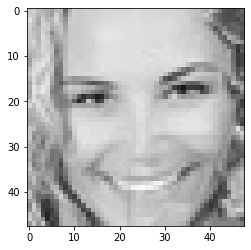

In [8]:
from keras.preprocessing import image
img = image.load_img("/content/test/test-private/happy/PrivateTest_10077120.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [9]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

94781440/94765736 [==============================] - 3s 0us/step


In [10]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [11]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [12]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

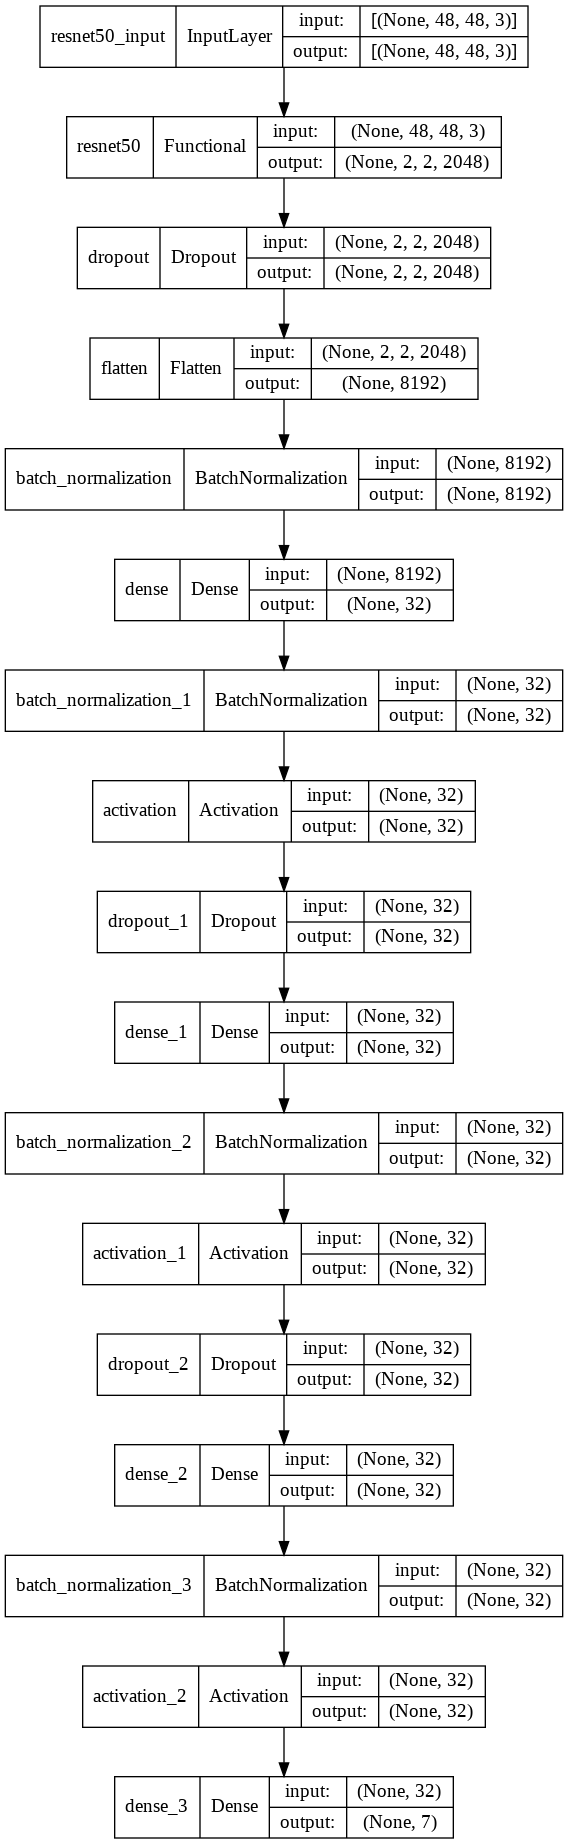

In [13]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [14]:
from livelossplot import PlotLossesKeras
#from livelossplot import PlotLossesTensorFlowKeras
from keras import backend as K

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [16]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
history=model.fit(train_generator,validation_data=validation_generator,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.6833 - accuracy: 0.8602 - precision: 0.5937 - recall: 0.0669 - auc: 0.7260 - f1_score: 0.1194

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


449/449 [==============================] - 31s 69ms/step - loss: 1.6833 - accuracy: 0.8602 - precision: 0.5937 - recall: 0.0669 - auc: 0.7260 - f1_score: 0.1194 - val_loss: 1.5769 - val_accuracy: 0.8655 - val_precision: 0.7530 - val_recall: 0.0875 - val_auc: 0.7767 - val_f1_score: 0.1385 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 31s 70ms/step - loss: 1.6321 - accuracy: 0.8622 - precision: 0.6118 - recall: 0.0978 - auc: 0.7488 - f1_score: 0.1678 - val_loss: 1.5488 - val_accuracy: 0.8672 - val_precision: 0.7242 - val_recall: 0.1134 - val_auc: 0.7869 - val_f1_score: 0.1700 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 31s 69ms/step - loss: 1.6019 - accuracy: 0.8643 - precision: 0.6336 - recall: 0.1180 - auc: 0.7616 - f1_score: 0.1981 - val_loss: 1.5464 - val_accuracy: 0.8667 - val_precision: 0.7386 - val_recall: 0.1039 - val_auc: 0.7878 - val_f1_score: 0.1621 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 31s 69ms/step - lo

In [19]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(validation_generator)
print('test loss, test acc:', results_test)


# Evaluate on test data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


test loss, test acc: [1.4656072854995728, 0.8724275231361389, 0.697125256061554, 0.18918919563293457, 0.8105632066726685, 0.27032727003097534]


In [20]:
import numpy as np
!pip install imutils
import imutils
import cv2

In [21]:
orig = cv2.imread("/content/test/test-private/happy/PrivateTest_10077120.jpg")
resized = cv2.resize(orig, (48, 48))

In [22]:
from tensorflow.keras.applications import imagenet_utils

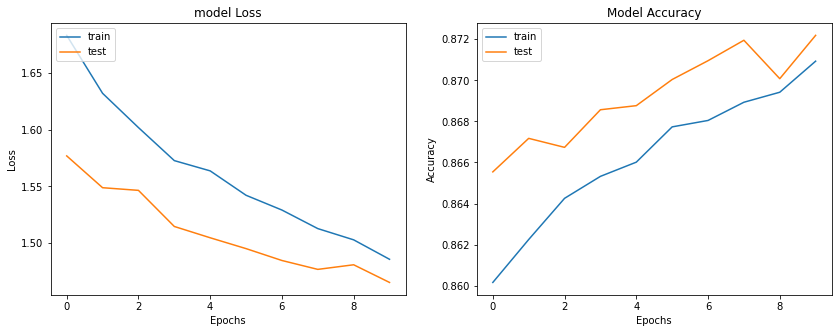

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion Matrix
[[ 450    0  204 1266  748  806  521]
 [  40    0   21  139   69   98   69]
 [ 484    0  224 1282  718  869  520]
 [ 813    0  400 2249 1301 1546  906]
 [ 528    0  287 1543  931 1020  656]
 [ 522    0  252 1519  855 1019  663]
 [ 383    0  170  981  534  702  401]]
Classification Report
              precision    recall  f1-score   support

       Anger       0.14      0.11      0.12      3995
     Disgust       0.00      0.00      0.00       436
        Fear       0.14      0.05      0.08      4097
       Happy       0.25      0.31      0.28      7215
     Neutral       0.18      0.19      0.18      4965
     Sadness       0.17      0.21      0.19      4830
    Surprise       0.11      0.13      0.12      3171

    accuracy                           0.18     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.18      0.17     28709



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


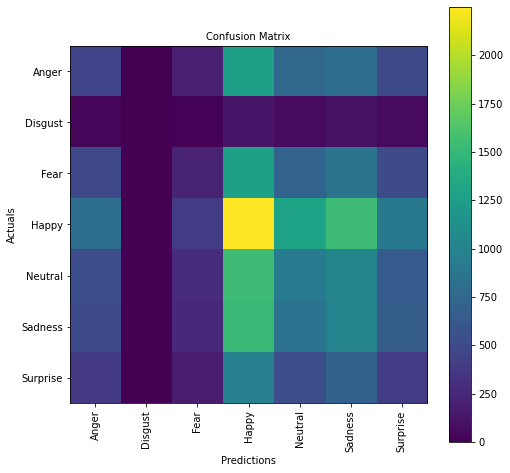

In [25]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}
Class_labels  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(CLASS_LABELS)
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.grid(False)
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[112   0  42 112  82 121  22]
 [ 17   0   3  13  10   9   3]
 [ 86   0  71  79  67 135  90]
 [ 53   0  15 623  65  91  32]
 [ 53   0  19 154 259 109  32]
 [ 69   0  26 100  94 286  19]
 [ 26   0  37  36  38  14 265]]
Classification Report
              precision    recall  f1-score   support

       Anger       0.27      0.23      0.25       491
     Disgust       0.00      0.00      0.00        55
        Fear       0.33      0.13      0.19       528
       Happy       0.56      0.71      0.62       879
     Neutral       0.42      0.41      0.42       626
     Sadness       0.37      0.48      0.42       594
    Surprise       0.57      0.64      0.60       416

    accuracy                           0.45      3589
   macro avg       0.36      0.37      0.36      3589
weighted avg       0.42      0.45      0.43      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


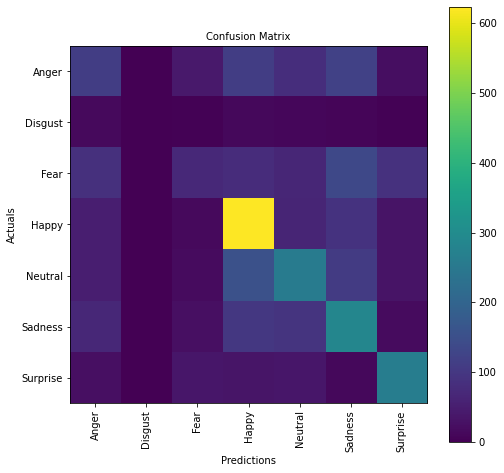

In [26]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}
Class_labels  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(CLASS_LABELS)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.xlabel('Predictions', fontsize=10)
plt.ylabel('Actuals', fontsize=10)
plt.title('Confusion Matrix', fontsize=10)
plt.grid(False)
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

57/57 [==============================] - 3s 56ms/step - loss: 1.4630 - accuracy: 0.8734 - precision: 0.7099 - recall: 0.1923 - auc: 0.8107 - f1_score: 0.2751


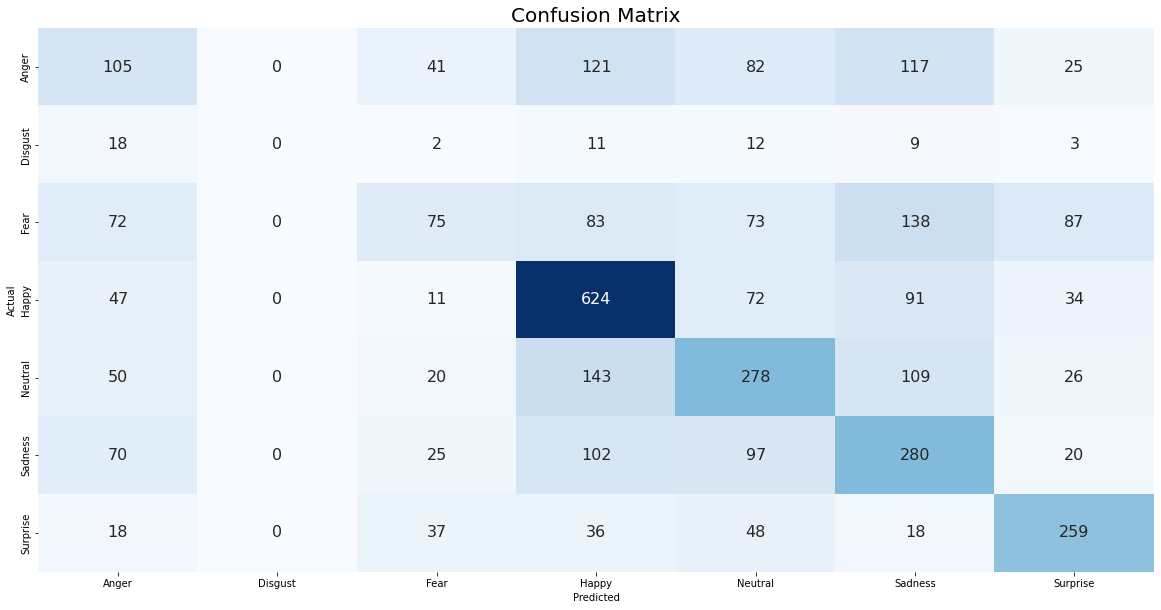

In [27]:
import seaborn as sns
import pandas as pd
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]
model.evaluate(validation_generator)
preds = model.predict(validation_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(validation_generator.labels)
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

57/57 [==============================] - 3s 55ms/step - loss: 1.4571 - accuracy: 0.8720 - precision: 0.6929 - recall: 0.1867 - auc: 0.8136 - f1_score: 0.2636


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()


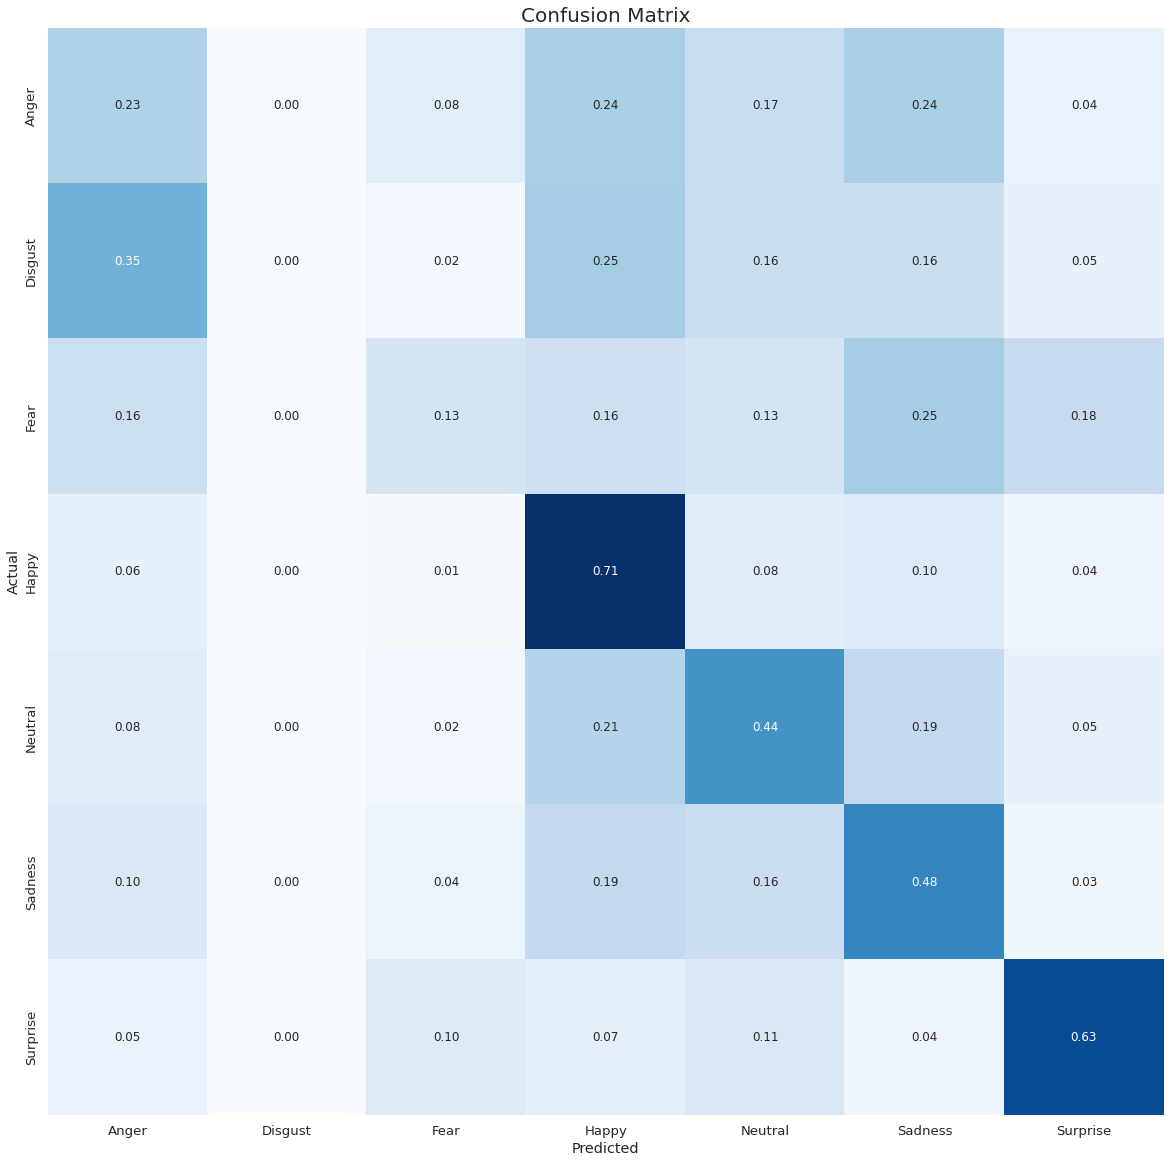

In [28]:
import seaborn as sns
import pandas as pd
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
CLASS_LABELS_EMOJIS = ["👿", "🤢" , "😱" , "😊" , "😐 ", "😔" , "😲" ]
model.evaluate(validation_generator)
preds = model.predict(validation_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(validation_generator.labels)
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax = sns.heatmap(cmn, cbar=False,fmt='.2f', cmap="Blues", annot=True, annot_kws={"size": 12})

ROC AUC score: 0.8115837498472871


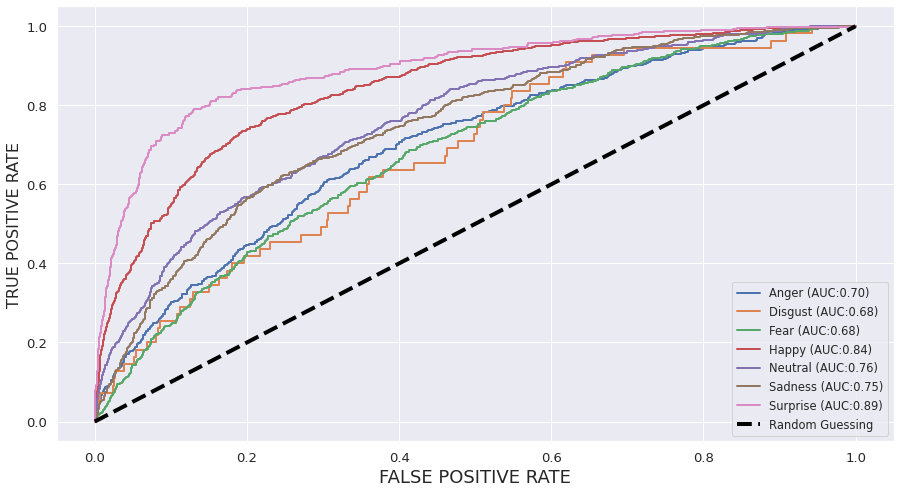

In [29]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [30]:
test_prob = model.predict(validation_generator)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == validation_generator.classes)

print(test_accuracy)

0.44692114795207577


In [31]:
import pandas as pd
df = pd.DataFrame(cm)
print(df)

Predicted  Anger  Disgust  Fear  Happy  Neutral  Sadness  Surprise
Actual                                                            
Anger        111        0    39    120       83      116        22
Disgust       19        0     1     14        9        9         3
Fear          83        0    68     82       68      132        95
Happy         50        0    12    625       73       87        32
Neutral       51        0    15    134      276      116        34
Sadness       62        0    24    111       95      285        17
Surprise      19        0    40     31       46       16       264


In [32]:
ranked_pred = np.argsort(test_prob, axis=1)
for k in range(7):
    correct = validation_generator.classes.reshape(-1,1) == ranked_pred[:, -(k+1):]
    top_k_acc = np.sum(correct) / len(validation_generator.classes)
    print(f'Top {k} Accuracy: {top_k_acc}')

Top 0 Accuracy: 0.44692114795207577
Top 1 Accuracy: 0.641961549178044
Top 2 Accuracy: 0.7762607968793536
Top 3 Accuracy: 0.8790749512398996
Top 4 Accuracy: 0.9509612705488995
Top 5 Accuracy: 0.983560880468097
Top 6 Accuracy: 1.0
